In [81]:
import numpy as np
from librosa import load
from matplotlib import rcParams
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.signal.windows import hann
from pymongo import MongoClient

In [82]:
rcParams['figure.dpi'] = 100

client = MongoClient('localhost', port=27017)
db = client.DAFi
collection = 'pairs'
if collection not in db.list_collection_names():
    db.create_collection(collection)

In [83]:
fs = 44100
win_size = 1024
anchor_offset = 3
target_zone_size = 5
keep_targets_ratio = 0.8
precision = 6
time_res = win_size/fs
database = {}

In [84]:
def compute_spectrogram(audio_path, plot_spec=False, plot_filtered_spec=False):
    samples, _ = load(audio_path, sr=fs, mono=True)
    freq, time, fft_values = spectrogram(samples, fs=fs, window=hann(win_size), noverlap=0, nfft=win_size, detrend=False, mode='magnitude', nperseg=win_size)
    if(plot_spec):
        plt.figure()
        plt.pcolormesh(time, freq/1000, 20*np.log10(fft_values),cmap='BrBG')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title('Audio Spectrogram')
        plt.colorbar()
        plt.show()
    
    filtered_spectrogram = filter_spectrogram(fft_values, time.size, plot=plot_filtered_spec)
    
    return filtered_spectrogram

In [85]:
def filter_spectrogram(fft_values, time_slices, plot=False):
    # logarithmic_bands = [(0,10), (10,20), (20,40), (40,80), (80,160), (160,512)]
    logarithmic_bands = [(0,20), (20,60), (60,120), (120,240), (240,512)]
    nbands = len(logarithmic_bands)
    filtered_spectrogram = {}
    slice_avgs = np.zeros((time_slices, nbands))

    for time_slice in range(time_slices):
        temp = []
        slice_avg = 0
        
        for i, band in enumerate(logarithmic_bands):
            fft_slice = fft_values[band[0]:band[1], time_slice]
            # find strongest frequency point in band
            idx = np.argmax(fft_slice)
            slice_avgs[time_slice][i] = fft_slice[idx]
            slice_avg += fft_slice[idx]
            temp.append((time_slice, band[0]+idx, fft_slice[idx], i))

        slice_avg /= nbands

        # Keep points stronger than the slice avg
        for (time_slice, freq_bin, mag, band_num) in temp:
            if mag >= slice_avg:
                if not time_slice in filtered_spectrogram:
                    filtered_spectrogram[time_slice] = []
                filtered_spectrogram[time_slice].append((freq_bin, mag, band_num))

    slice_avgs = np.mean(slice_avgs, axis=0)

    # Drop points weaker than the mean in band across entire song
    for time_slice, points in filtered_spectrogram.items():
        points = [freq_bin for (freq_bin, _, _) in list(filter(lambda pt: pt[1] >= slice_avgs[pt[2]], points))]
        filtered_spectrogram[time_slice] = points

    filtered_spectrogram = dict(filter(lambda couple: len(couple[1]) > 0, filtered_spectrogram.items()))

    if(plot):
        plt.figure()
        for slice, points in filtered_spectrogram.items():
            plt.scatter(slice*np.ones(len(points))*time_res, points, marker='x', c='r')

        for band in logarithmic_bands:
            plt.axhline(y=band[0], color='k', linestyle='-')

        plt.ylim(0, win_size/2)
        plt.xlabel('Time(s)')
        plt.ylabel('Frequency bins')
        plt.title('Filtered Spectrogram')
        plt.show()

    return filtered_spectrogram

In [86]:
def hash_song(filtered_spectrogram, songId=None, insert=False):
    pairs = {}
    sorted_points = []

    for time in sorted(filtered_spectrogram.keys()):
        for freq in sorted(filtered_spectrogram[time]):
            sorted_points.append((time, freq))
    
    total_pts = len(sorted_points)

    t_ap, f_ap = sorted_points[0][0], sorted_points[0][1]

    last_ap = total_pts - target_zone_size - anchor_offset + 1

    for ap in range(last_ap):
        t_ap, f_ap = sorted_points[ap][0], sorted_points[ap][1]
        target_zone = (ap + anchor_offset, ap + anchor_offset + target_zone_size)
        for target_pt in range(target_zone[0], target_zone[1]):
            t_tp, f_tp = sorted_points[target_pt][0], sorted_points[target_pt][1]
            address = (f_ap, f_tp, round((t_tp - t_ap) * time_res, precision))
            couple = (round(t_ap * time_res, precision), songId)

            if address not in pairs.keys():
                pairs[address] = []
            pairs[address].append(couple if insert else couple[0])
    
    if(insert):
        for address, couples in pairs.items():
            if(address in database):
                database[address].extend(couples)
            else:
                database[address] = couples
    return pairs, total_pts

In [87]:
def filter_database_song(song_ids):
	couples_grouped_by_song_id = {}
	for song_id in song_ids:
		couples_grouped_by_song_id[song_id] = {}

	for address, couples in database.items():
		for couple in couples:
			t_ap, song_id = couple[0], couple[1]
			if song_id in song_ids:
				if address not in couples_grouped_by_song_id[song_id].keys():
					couples_grouped_by_song_id[song_id][address] = []
				couples_grouped_by_song_id[song_id][address].append(t_ap)
	return couples_grouped_by_song_id

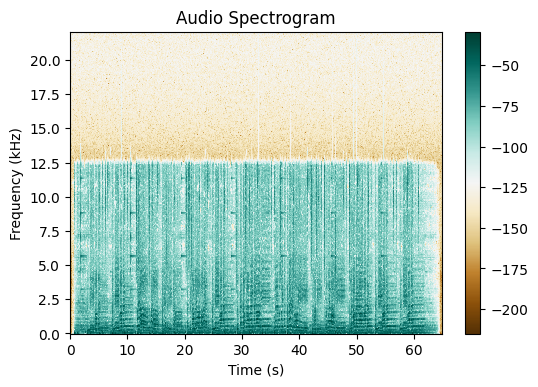

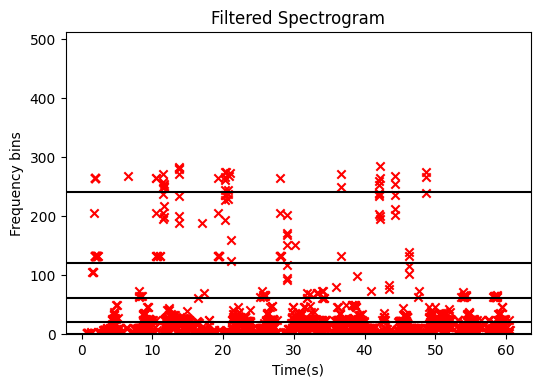

In [88]:
song_id = 1
audio_path = 'songs/NationalSongIndia.wav'
filtered_spectrogram = compute_spectrogram(audio_path, plot_spec=True, plot_filtered_spec=True)
hash_song(filtered_spectrogram, song_id, insert=True);

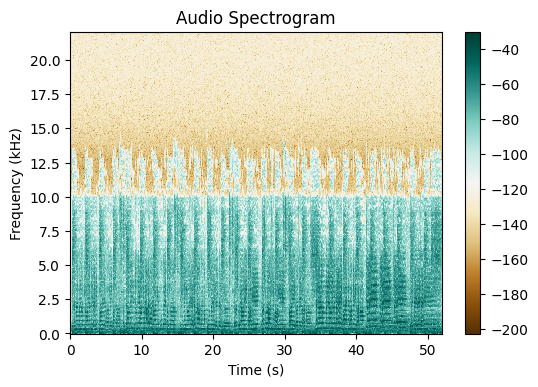

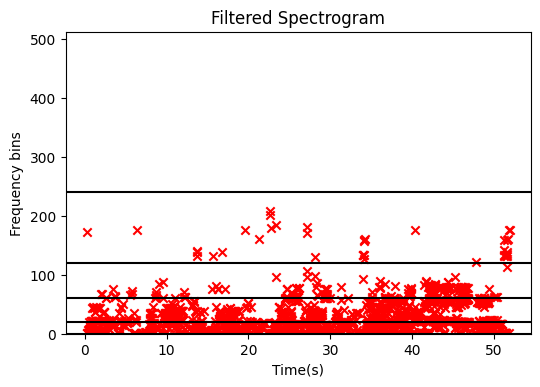

In [89]:
song_id = 2
audio_path = 'songs/NationalAnthemIndia.wav'
filtered_spectrogram = compute_spectrogram(audio_path, plot_spec=True, plot_filtered_spec=True)
hash_song(filtered_spectrogram, song_id, insert=True);

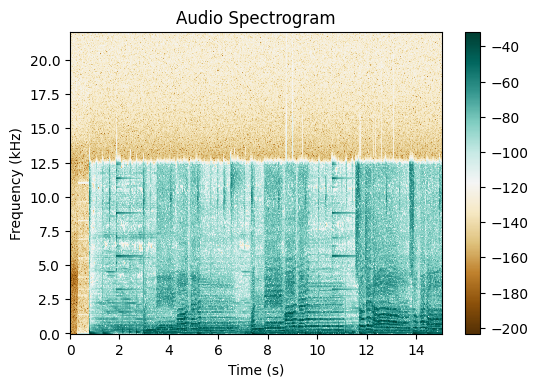

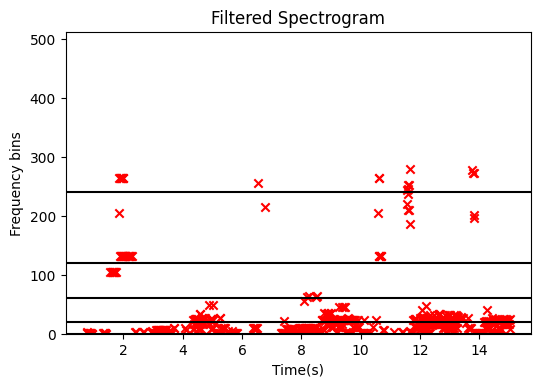

In [93]:
test_audio_path = 'test/NAS_1.wav'
filtered_spectrogram = compute_spectrogram(test_audio_path, plot_spec=True, plot_filtered_spec=True)
pairs, total_pts = hash_song(filtered_spectrogram)

In [94]:
matches = []

for address in pairs.keys():
    if address in database:
        f_ap = address[0]
        matches.append((f_ap, database[address]))

# result filtering

hits = {}
for (f_ap, couples) in matches:
    for couple in couples:
        if (f_ap, couple) not in hits:
            hits[(f_ap, couple)] = 0
        hits[(f_ap, couple)] += 1


filtered_matches = [match for match, count in hits.items() if count >= target_zone_size]

common_target_zones = {}
for match in filtered_matches:
    song_id = match[1][1]
    if song_id not in common_target_zones:
        common_target_zones[song_id] = 0
    common_target_zones[song_id] += 1

candidate_song_ids = []
for song_id, count in common_target_zones.items():
    if count >= total_pts*keep_targets_ratio:
        candidate_song_ids.append(song_id)

if len(candidate_song_ids) == 0:
    print('No strong matches, finding best weak match...')
    candidate_song_ids = sorted(common_target_zones.keys())

# time coherency
couples_grouped_by_song_id = filter_database_song(candidate_song_ids)
coherent_notes = {}

best_match_song_id = -1
max_delta = 0

for song_id, pairs_dict in couples_grouped_by_song_id.items():
    deltas = {}
    for address, t_aps in pairs.items():
        for t_ap in t_aps:
            if address not in pairs_dict:
                continue
            t_tps = pairs_dict[address]
            for t_tp in t_tps:
                delta = round(t_tp - t_ap, precision)
                if delta not in deltas:
                    deltas[delta] = 0
                deltas[delta] += 1
    # keep best delta
    best_delta = max(deltas, key=deltas.get)
    max_delta = max(deltas[best_delta], max_delta)
    coherent_notes[song_id] = (best_delta, deltas[best_delta])
    best_match_song_id = (best_match_song_id if deltas[best_delta] < max_delta else song_id)

print('Best match song id:', best_match_song_id, '\ndelta =', abs(coherent_notes[best_match_song_id][0]), 'seconds')

No strong matches, finding best weak match...
Best match song id: 1 
delta = 0.04644 seconds
